In [1]:
%matplotlib inline
%run ../../import_envs.py
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 1.1.0 cuda: True


In [2]:
## Load dataset
data_path = "../../../rings_varying_radius_c2k"
Data = torch.from_numpy(np.load(data_path + '/obs.npy')).float()
NUM_DATASETS, N, D = Data.shape
K = 3 ## number of clusters
SAMPLE_SIZE = 1
MCMC_SIZE = 10
BATCH_SIZE = 20
NUM_EPOCHS = 1000

In [58]:
from torch.distributions.one_hot_categorical import OneHotCategorical as cat
import torch.nn.functional as F
from torch.distributions.normal import Normal
import math

def Gibbs_z(obs, obs_mu, radi):
    S, B, N, D = obs.shape
    K = obs_mu.shape[-2]
    prior_pi = torch.ones(K) * (1./ K)
    noise_sigma = torch.ones((S, B, K, N)) * 0.05
    obs_mu_expand = obs_mu.unsqueeze(-2).repeat(1, 1, 1, N, 1) # S * B * K * N * D
    obs_expand = obs.unsqueeze(2).repeat(1, 1, K, 1, 1) #  S * B * K * N * D
    distance = ((obs_expand - obs_mu_expand)**2).sum(-1).sqrt()
    obs_dist = Normal(radi.repeat(1, 1, 1, N),  noise_sigma)
    log_distance = (obs_dist.log_prob(distance) - (2*math.pi*distance).log()).transpose(-1, -2) + prior_pi.log() # S * B * N * K
    q_pi = F.softmax(log_distance, -1)
    state = cat(q_pi).sample()
    return state

def sample_prior(sample_size, batch_size):
    p_mu = Normal(torch.zeros((K, D)), torch.ones((K, D)) * 5)
    obs_mu = p_mu.sample((sample_size, batch_size,))
    return obs_mu


def Gibbs_mu(obs, state):
    D = obs.shape[-1]
    K = state.shape[-1]
    stat1 = state.sum(-2)
    stat1[stat1 == 0.0] = 1.0
    states_expand = state.unsqueeze(-1).repeat(1, 1, 1, 1, D)
    obs_expand = obs.unsqueeze(-1).repeat(1, 1, 1, 1, K).transpose(-1, -2)
    stat2 = (states_expand * obs_expand).sum(2) #  S * B * K * D
    mu = stat2 / stat1.unsqueeze(-1).repeat(1, 1, 1, D)
    return mu

def Gibbs_radi(obs, state, obs_mu):
    S, B, N, D = obs.shape
    K = state.shape[-1]
    obs_mu_expand = obs_mu.unsqueeze(-2).repeat(1, 1, 1, N, 1) # S * B * K * N * D
    obs_expand = obs.unsqueeze(2).repeat(1, 1, K, 1, 1) #  S * B * K * N * D
    radi = ((obs_expand - obs_mu_expand)**2).sum(-1).sqrt().mean(-1).unsqueeze(-1) # S * B * K * 1
    return radi

In [60]:
indices = torch.arange(NUM_DATASETS)
step = 2
batch_indices = indices[step*BATCH_SIZE : (step+1)*BATCH_SIZE]
obs = Data[batch_indices]
obs = shuffler(obs).repeat(SAMPLE_SIZE, 1, 1, 1)
Iterations = 500
obs_mu = sample_prior(SAMPLE_SIZE, BATCH_SIZE)
for i in range(Iterations):
    radi = Gibbs_radi(obs, state, obs_mu)
    Gibbs_z(obs, obs_mu, radi)
    obs_mu = Gibbs_mu(obs, state)


In [61]:
def plot_samples(obs, obs_mu, state, K):
    colors = ['r', 'b', 'g']
    fig = plt.figure(figsize=(3,60))
    xs = obs[0]
    B, N, D = xs.shape
    gs = gridspec.GridSpec(BATCH_SIZE, 1)
    gs.update(left=0.0 , bottom=0.0, right=1.0, top=1.0, wspace=0, hspace=0)    
    E_mu = obs_mu[0]
    E_z = state[0]
    for b in range(B):
        ax = fig.add_subplot(gs[b, 0])
        assignments = E_z[b].argmax(-1)
        for k in range(K):
            xk = xs[b][np.where(assignments == k)]
            ax.scatter(xk[:, 0], xk[:, 1], c=colors[k], alpha=0.2)
        ax.set_ylim([-7, 7])
        ax.set_xlim([-7, 7])

CPU times: user 982 ms, sys: 20.2 ms, total: 1 s
Wall time: 172 ms


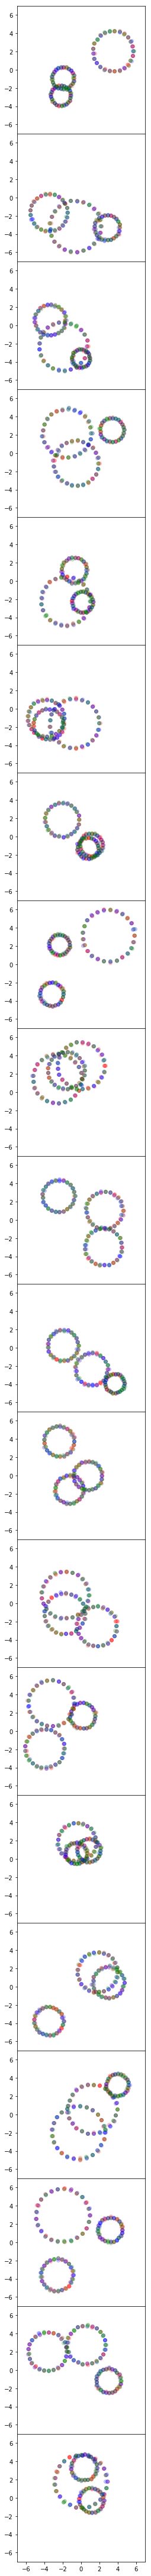

In [62]:
%time plot_samples(obs, obs_mu, state, K)

In [47]:
obs.shape

torch.Size([1, 20, 300, 2])

In [ ]:
incremental_gap = symkls_test.cpu().data.numpy()[1:]
M = incremental_gap.shape[0]
overall_gap = np.zeros(M)
for m in range(M):
    overall_gap[m] = incremental_gap[:m+1].sum()

In [ ]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
plt.yscale("log")
ax.plot(incremental_gap, label="incremental gap")
ax.plot(overall_gap, label='overall gap')
ax.legend(fontsize=14)
ax.set_xlabel('Steps')